# NeuralNetwork

## Чтобы установить ipywidgets:

`!pip install ipywidgets`

__Для тех кто на Jupyter Notebook:__

`!jupyter nbextension enable --py widgetsnbextension`

__Для тех, кто на Jupyter Lab:__

`!jupyter labextension install @jupyter-widgets/jupyterlab-manager`

In [ ]:
# в моем случае это Jupyter Lab, поэтому я прямо из ноутбука могу доустановить нужный модель

# прежде виджет нужно скачать
!pip install ipywidgets

# И далее установить виджет в jupyter lab и активировать его
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


# По материалам <u>[Neural Network from scratch](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)</u>

In [3]:
import pandas as pd
import numpy as np

# функция активации нейорна
def sigmoid(s):    
    return 1/(1 + np.exp(-s))

# Производная сигмоиды для метода обратного распространения ошибки (backpropagation)
def sigmoid_deriv(s):
    return s * (1 - s)

# Функция активации выходного слоя Softmax. 
# Первое что гугл выдал: https://www.machinelearningmastery.ru/the-softmax-function-neural-net-outputs-as-probabilities-and-ensemble-classifiers-9bd94d75932/
# Softmax формирует интерпретируемость выходного слоя как набор вероятностей отнесения каждого выходного нейрона как
# вероятности отнесения входного вектора к какой-то одной из категорий (при условии, что мы используем softmax как функцию активации выходного слоя и кросс-энтропию для функции потерь.
# Сумма всех вероятностей выходного слоя равна единице.
# Так например, если предсказываем ирисы, то у нас есть три категории. И тогда у нас будет три нейрона на выходном слое.
# Каждый нейрон показывает вероятность отнесения входного вектора к своей категории. 
# Например выходной вектор с функцией активации softmax выдаёт такой вектор [0.31, 0.52, 0.17]
# Его можно интерпретировать следующим образом: второй нейрон (средний) имеет самую большую вероятность, 
# значит предполагаем, что это вторая категория.
def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)


def cross_entropy(pred, real):
    n_samples = real.shape[0]
    residuals = pred - real
    return residuals/n_samples


def error(pred, real):
    n_samples = real.shape[0]
    logp = -np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

# Эта та же самая Accuracy, что и в задаче с Титаником
def get_accuracy(model, X, y):
    accuracy = 0
    for xx, yy in zip(X,y):
        prediction = model.predict(xx)
        if prediction == np.argmax(yy):
            accuracy += 1
    return accuracy/len(X)


class NN:
    # Инициализируем экземпляр класса
    def __init__(self, X, y, neurons = 128, lr = 0.5):
        self.X = X
        self.y = y        
        self.lr = lr
        ip_dim = X.shape[1] #input layer
        op_dim = y.shape[1] #output layer
        
        self.w1 = np.random.randn(ip_dim, neurons) #weights
        self.b1 = np.zeros((1, neurons)) #biases
        
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        
        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1, op_dim))


    def feedforward(self):
        z1 = np.dot(self.X, self.w1) + self.b1
        self.tmp_z1 = z1
        self.a1 = sigmoid(z1)

        z2 = np.dot(self.a1, self.w2) + self.b2
        self.tmp_z2 = z2
        self.a2 = sigmoid(z2)

        z3 = np.dot(self.a2, self.w3) + self.b3
        self.tmp_z3 = z3
        self.a3 = softmax(z3) 
    

    def get_loss(self):
        loss = error(self.a3, self.y)
        return loss
    
    
    def backprop(self):
        a3_delta = cross_entropy(self.a3, self.y) #weights3
        z2_delta = np.dot(a3_delta, self.w3.T)
        
        a2_delta = z2_delta * sigmoid_deriv(self.a2) #weights2
        z1_delta = np.dot(a2_delta, self.w2.T)
        
        a1_delta = z1_delta * sigmoid_deriv(self.a1) #weights1
        
        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.X.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)
        
        
    def predict(self, data):
        self.X = data
        self.feedforward()
        return self.a3.argmax()    

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import HTML
import time

dig = load_digits() # получаем датасет
onehot_target = pd.get_dummies(dig.target)
dig.keys()
X_train, X_test, y_train, y_test = train_test_split(dig.data, onehot_target, 
                                                    test_size = 0.1, random_state=42)

nn = NN(X_train, np.array(y_train), neurons = 128, lr = 0.2)

epochs = 300

h = HTML(); display(h)
previous_loss = 0
previous_validation_loss = 100
ts = time.time()
for epoch in range(epochs):
    nn.feedforward() # прямой прогон модели
    loss = nn.get_loss()
    # проверка, что если модель начала
    # У нас есть X_test, y_test, но по ним будем проверять финальное качество модели. 
    # Однако ничто не мешает обучающую выборку разбить еще раз на обучающую\валидационную и проверять
    # модель на переобучение\необходимость сделать остановку в обуччении
    # validation_loss = nn.get_loss(X_validation, y_validation) 
    h.value = '''
        Error on {epoch} epoch: {loss:.2%} (change: {change:>8.6%})<br>
        Time passed: {time:.1f}s'''.format(
        epoch = epoch, loss = loss, change = loss - previous_loss, 
        time=time.time()-ts)\
        .replace(' ', '&nbsp;')    
    nn.backprop() # обновляем веса
    
    previous_loss = loss
        
print("Train accuracy: {0:>10.2%}".format(get_accuracy(nn, X_train, np.array(y_train))))
print(" Test accuracy: {0:>10.2%}".format(get_accuracy(nn, X_test, np.array(y_test))))

HTML(value='')

Train accuracy:     96.91%
 Test accuracy:     82.22%


#  Пару абзацев про датасет

In [11]:
# В качестве датасета используется 
dig = load_digits() # загружаем один из датасетов через sklearn
print(type(dig)) # Это не DICT
dig.keys() #Но ведет себя почти как dict
dig['data']

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [120]:
print(dig['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [119]:
 dig['data'][0] # один из подаваемых векторов (X)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [17]:
dig['images'][0] # эти же данные, но уже в удобном для отрисовки в human-readable формате

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

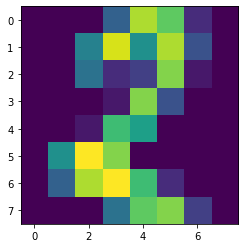

In [23]:
# Так выглядит один из подаваемых экземпляров
plt.imshow(dig['data'][50].reshape(8,8))

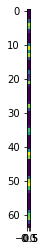

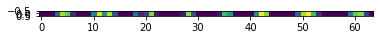

In [118]:
#Вот так выглядит входной вектор
plt.imshow(dig['data'][50].reshape(64,1))
plt.show()
# или так
plt.imshow(dig['data'][50].reshape(1,64))
plt.show()

In [ ]:
На самостоятельное изучение:

1) Поиграться с архитектурой сети:
    + Добавить\Удалить скрытые слои (обновить методы feedforward, backprop, __init__)
    + Посмотреть как зависит переобучение модели от learning rate (lr)
    + Посмотреть как зависит переобучение модели от количества эпох
    + Заменить метод активации нейрона с sigmoid на ReLU
    + На каждой эпохе валидировать модель на отложенной выборке
    + Если оценка валидации перестала изменяться (или начала ухудшаться) - прекратить обучение сети
    + ?Визуализировать вектор изменения первого скрытого слоя (см. пример с разворотом входящего вектора в столбец)

2) Подменить датасет на iris
    + На ирисе входной вектор из 4 элементов - сделать архитектуру 1 скрытый слой и 4 нейрона
    + Инициализировать экземпляр NN, обучить и после забрать из модели weights\biases и ручками в эксельке посчитать
3) Подменить датасет на титаник
4) Построить confusion_maxtrix, classification_report
    

In [73]:
# Датасет для ириса
iris = pd.read_csv('../../data/raw/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# WTR:
+ ## <u>[Neural Network from scratch](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)</u>

+ ## <u>[Michael Nielsen __Neural Networks and Deep Learning__](http://neuralnetworksanddeeplearning.com/index.html)</u>
https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60
Функции активации https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a